## Validating a recording with RIGOR criteria

In [1]:
import one.alf.io as alfio
import matplotlib.pyplot as plt
from pathlib import Path
from ibllib.ephys.ephysqc import phy_model_from_ks2_path, spike_sorting_metrics_ks2
from phylib.io.alf import EphysAlfCreator
from ibllib.pipes.ephys_tasks import SpikeSorting
import numpy as np
from matplotlib import gridspec
from brainbox.processing import bincount2D, compute_cluster_average
from neuropixel import NP2Converter
import spikeglx
from ibldsp import voltage, utils
import scipy
import pandas as pd
import neuropixel

We need paths to both the raw ephys recording and the spikesorting output (in PHY format).

In [2]:
raw_data_path = Path("/Users/chris/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjects/KS046/2020-12-03/001/raw_ephys_data/probe00")
spikesorting_path = Path("/Users/chris/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjects/KS046/2020-12-03/001/spike_sorters/pykilosort/probe00/_kilosort_raw.output")

### Raw data metrics

First, we can confirm whether the data passes the visually assessed RIGOR criteria. To do this, we'll look at some raw data snippets. We apply IBL's destriping procedure to the snippets. This automatically corrects for some artifacts that would otherwise appear to exclude the recording.

In the raw AP band snippets below, we're looking for epileptiform activity, artifacts from the acquisition hardware, severe drift of the probe, and dead or noisy channels.

This recording is 4971.3346s long.


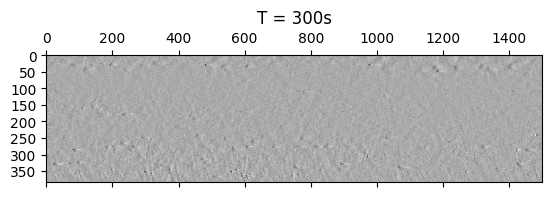

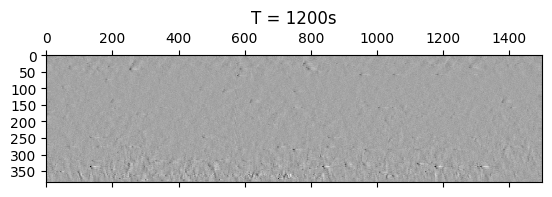

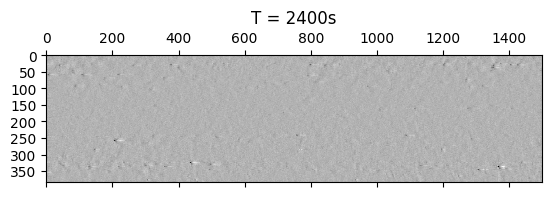

In [24]:
ap_file = next(raw_data_path.glob('*ap.*bin'), None)
sr = spikeglx.Reader(ap_file)

print(f"This recording is {sr.rl}s long.")

# pick some timepoints within the recording
t0s = int(sr.fs) * np.array([300, 1200, 2400])

for i, t0 in enumerate(t0s):
    t0 = t0s[i]
    t1 = t0 + int(0.05 * fs)

    raw = sr[t0:t1, :-sr.nsync].T
    processed = voltage.destripe(raw, fs)
    fig, ax = plt.subplots()
    ax.matshow(processed, cmap="gray")
    ax.set_title(f"T = {t0//fs}s")



Next we will make quantitative assessments of the noise level. 



In [10]:
processed.shape

(384, 1500)